<a href="https://colab.research.google.com/github/sedaoturak/dcgan_cahn-hilliard/blob/main/DCGAN_Cahn_Hillard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd.variable import Variable
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

import os
try:
	from google.colab import drive
	IN_COLAB = True
	drive.mount('/content/drive')
	PATH = '/content/drive/MyDrive/Colab Notebooks/' # change this with your drive's path
except:
	IN_COLAB = False
	PATH = os.getcwd()[:-9]

Mounted at /content/drive


# Load data

In [2]:
# define the directory to dataset (the folder having the bitmap images and their strain energy values in text files
with open(PATH+'toy_datasets/Mechanical_MNIST/Case1_input_patterns_64_x_64.txt', 'r') as f:
  g = np.loadtxt(f)
with open(PATH+'toy_datasets/Mechanical_MNIST/Case1_strain_energy.txt', 'r') as f:
  e = np.loadtxt(f)

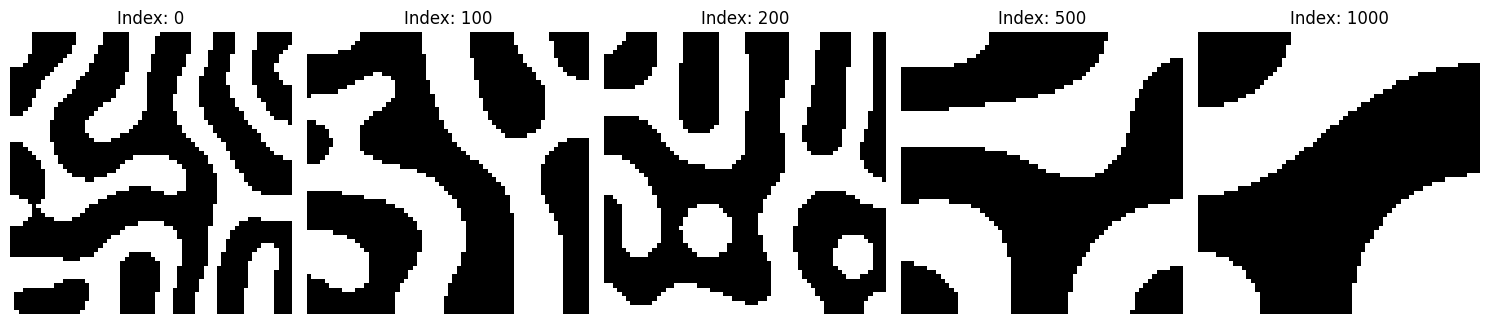

In [3]:
# visualize an image from dataset
img = g.reshape(37523,64,64) # reshape image dataset so that you'll get (number of images, first dimension, second dimension)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, idx in enumerate([0, 100, 200, 500, 1000]): #random indices of five images
    axes[i].imshow(img[idx, :, :], interpolation='nearest', cmap='binary')
    axes[i].set_title(f"Index: {idx}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Preprocessing

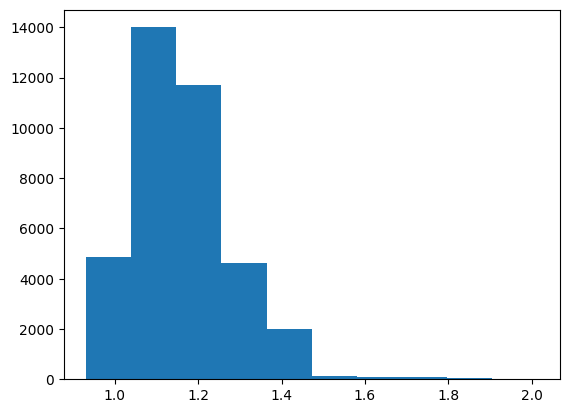

In [4]:
# visualize the distribution of the output (energy) values
# maximum energy (at the last index) is considered

fig, ax = plt.subplots()
ax.hist(e[:,-1])
plt.show()

In [5]:
# apply different preprocessing on the strain energy values to compare
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

# normalization
scaler = MinMaxScaler(feature_range=(0,1))
e_scaled = scaler.fit_transform(e[:,-1].reshape(-1, 1))

# power transformation
pt = PowerTransformer()
e_power = pt.fit_transform(e[:,-1].reshape(-1, 1))

# power transformation + normalization
scaler = MinMaxScaler(feature_range=(0,1))
e_power_scaled = scaler.fit_transform(e_power)

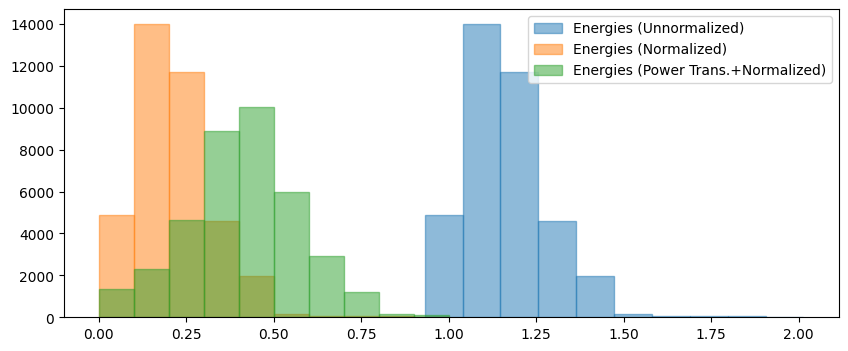

In [6]:
fig, axs = plt.subplots(figsize=(10,4))

axs.hist(e[:,-1], label=f'Energies (Unnormalized)', alpha=0.5, edgecolor='tab:blue', linewidth=1)
axs.hist(e_scaled, label=f'Energies (Normalized)', alpha=0.5, edgecolor='tab:orange', linewidth=1)
# axs.hist(e_power, label=f'Energies (Power Trans.)', alpha=0.5, edgecolor='tab:red', linewidth=1)
axs.hist(e_power_scaled, label=f'Energies (Power Trans.+Normalized)', alpha=0.5, edgecolor='tab:green', linewidth=1)
axs.legend()
plt.show()

In [7]:
# create Dataset class to define the dataset oject

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        # Normalize images to [-1, 1] for DCGAN Tanh output
        self.images = (torch.tensor(images, dtype=torch.float32).unsqueeze(1) / 0.5) - 1.0
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

images = g.reshape((37523,64,64))
energies = e_power_scaled.ravel()

dataset = CustomDataset(images, energies)

# --- Updated: Train-Test Split ---
train_set_size = int(len(dataset) * 0.8)
val_set_size = len(dataset) - train_set_size
trainset, valset = random_split(dataset, [train_set_size, val_set_size])

batch_size = 64
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

# Model

In [21]:
# Define the model
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, features_g * 4, 4, 1, 0),      # 4x4
            self._block(features_g * 4, features_g * 8, 4, 2, 1), # 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # 32x32
            nn.ConvTranspose2d(features_g * 2, channels_img, 4, 2, 1),
            nn.Sigmoid()
            )

    def _block(self, in_c, out_c, kernel, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel, stride, padding, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
            )

    def forward(self, x):
        return self.gen(x)

# Discriminator: Image -> Probability
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, 4, 2, 1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            # self._block(features_d * 2, features_d * 4, 4, 2, 1),
            # self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 2, 1, 4, 2, 0),
            nn.Sigmoid(),
        )

    def _block(self, in_c, out_c, kernel, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel, stride, padding, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

# Training

In [24]:
# Initialize Models
device = "cuda" if torch.cuda.is_available() else "cpu"

z_dim = 64
gen = Generator(z_dim=z_dim, channels_img=1, features_g=64).to(device)
disc = Discriminator(channels_img=1, features_d=64).to(device)
opt_gen = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))
criterion = torch.nn.BCELoss()

# Training loop
epochs = 50
train_loss_G, train_loss_D = [], []
val_loss_G, val_loss_D = [], []

for epoch in range(epochs):
    gen.train()
    disc.train()
    running_g_loss, running_d_loss = 0.0, 0.0

    # training
    for batch_idx, (real, _) in enumerate(tqdm(trainloader, desc=f"Epoch {epoch} Training")):
        real = real.to(device)
        batch_curr = real.shape[0]
        noise = torch.randn(batch_curr, z_dim, 1, 1).to(device)
        fake = gen(noise)

        # train Discriminator
        disc_real = disc(real).view(-1)
        loss_d_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).view(-1)
        loss_d_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_d_real + loss_d_fake) / 2

        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        # train Generator
        output = disc(fake).view(-1)
        loss_gen = criterion(output, torch.ones_like(output))

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        running_g_loss += loss_gen.item()
        running_d_loss += loss_disc.item()

    # validation
    disc.eval()
    gen.eval()
    running_val_d_loss = 0.0
    with torch.no_grad():
        for real, _ in valloader:
            real = real.to(device)
            batch_curr = real.shape[0]

            # Check how discriminator handles real validation images
            out_real = disc(real).view(-1)
            loss_v_real = criterion(out_real, torch.ones_like(out_real))

            # Check how discriminator handles fake images during validation
            noise = torch.randn(batch_curr, z_dim, 1, 1).to(device)
            fake = gen(noise)
            out_fake = disc(fake).view(-1)
            loss_v_fake = criterion(out_fake, torch.zeros_like(out_fake))

            running_val_d_loss += (loss_v_real + loss_v_fake).item() / 2

    # Save metrics
    train_loss_G.append(running_g_loss / len(trainloader))
    train_loss_D.append(running_d_loss / len(trainloader))
    val_loss_D.append(running_val_d_loss / len(valloader))

    print(f"Epoch {epoch}: G_Loss: {train_loss_G[-1]:.4f} | D_Loss: {train_loss_D[-1]:.4f} | Val_D_Loss: {val_loss_D[-1]:.4f}")

Epoch 0 Training: 100%|██████████| 470/470 [00:30<00:00, 15.49it/s]


Epoch 0: G_Loss: 2.3244 | D_Loss: 0.2274 | Val_D_Loss: 0.2532


Epoch 1 Training: 100%|██████████| 470/470 [00:30<00:00, 15.49it/s]


Epoch 1: G_Loss: 4.3322 | D_Loss: 0.0157 | Val_D_Loss: 0.1801


Epoch 2 Training: 100%|██████████| 470/470 [00:30<00:00, 15.46it/s]


Epoch 2: G_Loss: 5.4307 | D_Loss: 0.0045 | Val_D_Loss: 0.1492


Epoch 3 Training: 100%|██████████| 470/470 [00:30<00:00, 15.43it/s]


Epoch 3: G_Loss: 6.1444 | D_Loss: 0.0022 | Val_D_Loss: 0.1655


Epoch 4 Training: 100%|██████████| 470/470 [00:30<00:00, 15.59it/s]


Epoch 4: G_Loss: 6.7365 | D_Loss: 0.0012 | Val_D_Loss: 0.1361


Epoch 5 Training: 100%|██████████| 470/470 [00:30<00:00, 15.57it/s]


Epoch 5: G_Loss: 7.1977 | D_Loss: 0.0007 | Val_D_Loss: 0.1192


Epoch 6 Training: 100%|██████████| 470/470 [00:30<00:00, 15.57it/s]


Epoch 6: G_Loss: 7.6105 | D_Loss: 0.0005 | Val_D_Loss: 0.1537


Epoch 7 Training: 100%|██████████| 470/470 [00:30<00:00, 15.53it/s]


Epoch 7: G_Loss: 7.9891 | D_Loss: 0.0003 | Val_D_Loss: 0.1381


Epoch 8 Training: 100%|██████████| 470/470 [00:30<00:00, 15.54it/s]


Epoch 8: G_Loss: 8.3133 | D_Loss: 0.0002 | Val_D_Loss: 0.1426


Epoch 9 Training: 100%|██████████| 470/470 [00:30<00:00, 15.32it/s]


Epoch 9: G_Loss: 8.6558 | D_Loss: 0.0002 | Val_D_Loss: 0.1449


Epoch 10 Training: 100%|██████████| 470/470 [00:30<00:00, 15.33it/s]


Epoch 10: G_Loss: 8.9710 | D_Loss: 0.0001 | Val_D_Loss: 0.1183


Epoch 11 Training: 100%|██████████| 470/470 [00:31<00:00, 14.97it/s]


Epoch 11: G_Loss: 9.2413 | D_Loss: 0.0001 | Val_D_Loss: 0.0686


Epoch 12 Training: 100%|██████████| 470/470 [00:30<00:00, 15.42it/s]


Epoch 12: G_Loss: 9.5066 | D_Loss: 0.0001 | Val_D_Loss: 0.1006


Epoch 13 Training: 100%|██████████| 470/470 [00:30<00:00, 15.46it/s]


Epoch 13: G_Loss: 9.8147 | D_Loss: 0.0001 | Val_D_Loss: 0.1075


Epoch 14 Training: 100%|██████████| 470/470 [00:30<00:00, 15.53it/s]


Epoch 14: G_Loss: 10.1293 | D_Loss: 0.0000 | Val_D_Loss: 0.1278


Epoch 15 Training: 100%|██████████| 470/470 [00:31<00:00, 14.96it/s]


Epoch 15: G_Loss: 10.3720 | D_Loss: 0.0000 | Val_D_Loss: 0.1320


Epoch 16 Training: 100%|██████████| 470/470 [00:30<00:00, 15.39it/s]


Epoch 16: G_Loss: 10.6484 | D_Loss: 0.0000 | Val_D_Loss: 0.1326


Epoch 17 Training: 100%|██████████| 470/470 [00:30<00:00, 15.44it/s]


Epoch 17: G_Loss: 10.8869 | D_Loss: 0.0000 | Val_D_Loss: 0.1467


Epoch 18 Training: 100%|██████████| 470/470 [00:31<00:00, 15.16it/s]


Epoch 18: G_Loss: 11.1435 | D_Loss: 0.0000 | Val_D_Loss: 0.2069


Epoch 19 Training: 100%|██████████| 470/470 [00:30<00:00, 15.32it/s]


Epoch 19: G_Loss: 11.3733 | D_Loss: 0.0000 | Val_D_Loss: 0.1309


Epoch 20 Training: 100%|██████████| 470/470 [00:31<00:00, 15.14it/s]


Epoch 20: G_Loss: 11.6685 | D_Loss: 0.0000 | Val_D_Loss: 0.1261


Epoch 21 Training: 100%|██████████| 470/470 [00:30<00:00, 15.33it/s]


Epoch 21: G_Loss: 11.9728 | D_Loss: 0.0000 | Val_D_Loss: 0.1259


Epoch 22 Training: 100%|██████████| 470/470 [00:30<00:00, 15.48it/s]


Epoch 22: G_Loss: 12.2186 | D_Loss: 0.0000 | Val_D_Loss: 0.1732


Epoch 23 Training: 100%|██████████| 470/470 [00:30<00:00, 15.43it/s]


Epoch 23: G_Loss: 12.4536 | D_Loss: 0.0000 | Val_D_Loss: 0.1868


Epoch 24 Training: 100%|██████████| 470/470 [00:31<00:00, 14.89it/s]


Epoch 24: G_Loss: 12.6958 | D_Loss: 0.0000 | Val_D_Loss: 0.1748


Epoch 25 Training: 100%|██████████| 470/470 [00:30<00:00, 15.36it/s]


Epoch 25: G_Loss: 12.9675 | D_Loss: 0.0000 | Val_D_Loss: 0.2014


Epoch 26 Training: 100%|██████████| 470/470 [00:31<00:00, 14.97it/s]


Epoch 26: G_Loss: 13.2090 | D_Loss: 0.0000 | Val_D_Loss: 0.2404


Epoch 27 Training: 100%|██████████| 470/470 [00:30<00:00, 15.22it/s]


Epoch 27: G_Loss: 13.4948 | D_Loss: 0.0000 | Val_D_Loss: 0.1830


Epoch 28 Training: 100%|██████████| 470/470 [00:30<00:00, 15.57it/s]


Epoch 28: G_Loss: 13.7154 | D_Loss: 0.0000 | Val_D_Loss: 0.1989


Epoch 29 Training: 100%|██████████| 470/470 [00:30<00:00, 15.61it/s]


Epoch 29: G_Loss: 13.9407 | D_Loss: 0.0000 | Val_D_Loss: 0.2204


Epoch 30 Training: 100%|██████████| 470/470 [00:30<00:00, 15.49it/s]


Epoch 30: G_Loss: 14.1804 | D_Loss: 0.0000 | Val_D_Loss: 0.2393


Epoch 31 Training: 100%|██████████| 470/470 [00:30<00:00, 15.60it/s]


Epoch 31: G_Loss: 14.4990 | D_Loss: 0.0000 | Val_D_Loss: 0.2630


Epoch 32 Training: 100%|██████████| 470/470 [00:30<00:00, 15.60it/s]


Epoch 32: G_Loss: 14.7672 | D_Loss: 0.0000 | Val_D_Loss: 0.2789


Epoch 33 Training: 100%|██████████| 470/470 [00:30<00:00, 15.64it/s]


Epoch 33: G_Loss: 14.9849 | D_Loss: 0.0000 | Val_D_Loss: 0.2255


Epoch 34 Training: 100%|██████████| 470/470 [00:30<00:00, 15.56it/s]


Epoch 34: G_Loss: 15.2525 | D_Loss: 0.0000 | Val_D_Loss: 0.1769


Epoch 35 Training: 100%|██████████| 470/470 [00:30<00:00, 15.59it/s]


Epoch 35: G_Loss: 15.4932 | D_Loss: 0.0000 | Val_D_Loss: 0.1761


Epoch 36 Training: 100%|██████████| 470/470 [00:30<00:00, 15.54it/s]


Epoch 36: G_Loss: 15.7443 | D_Loss: 0.0000 | Val_D_Loss: 0.2865


Epoch 37 Training: 100%|██████████| 470/470 [00:30<00:00, 15.58it/s]


Epoch 37: G_Loss: 15.9921 | D_Loss: 0.0000 | Val_D_Loss: 0.1467


Epoch 38 Training: 100%|██████████| 470/470 [00:30<00:00, 15.57it/s]


Epoch 38: G_Loss: 16.2501 | D_Loss: 0.0000 | Val_D_Loss: 0.2401


Epoch 39 Training: 100%|██████████| 470/470 [00:30<00:00, 15.61it/s]


Epoch 39: G_Loss: 16.5208 | D_Loss: 0.0000 | Val_D_Loss: 0.2000


Epoch 40 Training: 100%|██████████| 470/470 [00:30<00:00, 15.58it/s]


Epoch 40: G_Loss: 16.7595 | D_Loss: 0.0000 | Val_D_Loss: 0.1782


Epoch 41 Training: 100%|██████████| 470/470 [00:30<00:00, 15.59it/s]


Epoch 41: G_Loss: 17.1100 | D_Loss: 0.0000 | Val_D_Loss: 0.2564


Epoch 42 Training: 100%|██████████| 470/470 [00:30<00:00, 15.58it/s]


Epoch 42: G_Loss: 17.3681 | D_Loss: 0.0000 | Val_D_Loss: 0.2309


Epoch 43 Training: 100%|██████████| 470/470 [00:30<00:00, 15.55it/s]


Epoch 43: G_Loss: 17.5682 | D_Loss: 0.0000 | Val_D_Loss: 0.2237


Epoch 44 Training: 100%|██████████| 470/470 [00:30<00:00, 15.58it/s]


Epoch 44: G_Loss: 16.2137 | D_Loss: 0.0085 | Val_D_Loss: 1.1098


Epoch 45 Training: 100%|██████████| 470/470 [00:30<00:00, 15.54it/s]


Epoch 45: G_Loss: 9.5298 | D_Loss: 0.0001 | Val_D_Loss: 1.7984


Epoch 46 Training: 100%|██████████| 470/470 [00:30<00:00, 15.58it/s]


Epoch 46: G_Loss: 10.2783 | D_Loss: 0.0001 | Val_D_Loss: 2.0350


Epoch 47 Training: 100%|██████████| 470/470 [00:30<00:00, 15.52it/s]


Epoch 47: G_Loss: 10.5203 | D_Loss: 0.0000 | Val_D_Loss: 2.3418


Epoch 48 Training: 100%|██████████| 470/470 [00:30<00:00, 15.57it/s]


Epoch 48: G_Loss: 11.1084 | D_Loss: 0.0000 | Val_D_Loss: 2.3056


Epoch 49 Training: 100%|██████████| 470/470 [00:30<00:00, 15.54it/s]


Epoch 49: G_Loss: 11.4591 | D_Loss: 0.0000 | Val_D_Loss: 2.5210


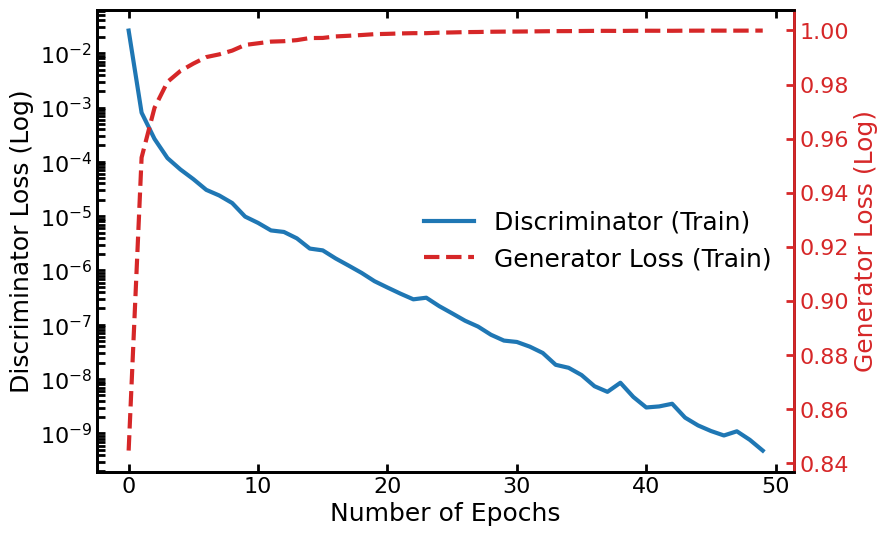

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 6))
font_size, ticklabel_size = 18, 16

color_d = 'tab:blue'
l1 = ax.plot(train_loss_D, '-', label='Discriminator (Train)', linewidth=3, color=color_d)

ax.set_ylabel('Discriminator Loss (Log)', fontsize=font_size)
ax.set_xlabel('Number of Epochs', fontsize=font_size)
ax.set_yscale('log')

ax.xaxis.set_tick_params(width=2, length=5, labelsize=ticklabel_size)
ax.yaxis.set_tick_params(width=2, length=5, labelsize=ticklabel_size)
ax.tick_params(which='both', width=2, length=6, top=True, right=True, direction='in')
plt.setp(ax.spines.values(), linewidth=2)


ax2 = ax.twinx()
color_g = 'tab:red'
l2 = ax2.plot(train_loss_G, '--', label='Generator Loss (Train)', linewidth=3, color=color_g)
ax2.tick_params(axis='y', colors=color_g, width=2, length=6, direction='in')
ax2.yaxis.label.set_color(color_g)
ax2.spines['right'].set_color(color_g)
ax2.yaxis.set_tick_params(labelsize=ticklabel_size)
ax2.set_ylabel('Generator Loss (Log)', fontsize=font_size, color=color_g)
ax2.set_yscale('log')
plt.setp(ax2.spines.values(), linewidth=2)

# legend
lns = l1 + l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, fontsize=font_size, loc='center right', frameon=False)
plt.show()

In [ ]:
# save the model
PATH = '/content/drive/MyDrive/Colab Notebooks'
torch.save(gen, os.path.join(PATH, 'mech_MNIST_generator.pt'))

torch.save(gen, os.path.join(PATH, 'mech_MNIST_discriminator.pt'))

# model_scripted = torch.jit.script(gen.cpu())
# model_scripted.save(os.path.join(PATH, f'mech_MNIST_generator.pt'))
# model_scripted = torch.jit.script(disc.cpu())
# model_scripted.save(os.path.join(PATH, f'mech_MNIST_discriminator.pt'))

In [ ]:
# load the pretrained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PATH = '/content/drive/MyDrive/Colab Notebooks'
gen = torch.load(os.path.join(PATH, 'mech_MNIST_generator.pt')).to(device)
disc = torch.load(os.path.join(PATH, 'mech_MNIST_discriminator.pt')).to(device)

# Reconstructed Images

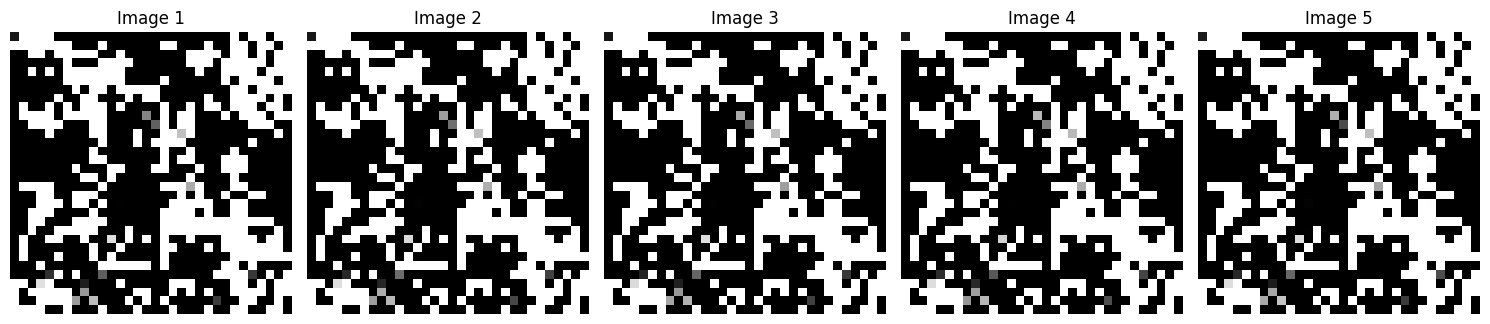

In [20]:
# generate random images to see the performance of the generator
def visualize_generated_images(generator, num_images=5, z_dim=64, device="cpu"):
    generator.eval()

    # create random noise (z): [num_images, z_dim, 1, 1]
    noise = torch.randn(num_images, z_dim, 1, 1).to(device)

    # generate images from noise
    with torch.no_grad():
        generated_images = generator(noise)

    generated_images = generated_images.cpu().numpy().squeeze(1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[i].imshow(generated_images[i], cmap='gray')
        axes[i].set_title(f"Image {i+1}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# generate 5 random images
visualize_generated_images(gen, num_images=5, z_dim=z_dim, device=device)